<a href="https://colab.research.google.com/github/tedteske/ndplex/blob/master/ndplex_array.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Generic n-Dimensional m-Plex (`ndplex`) Array: Class Definition


In [0]:
import numpy as np
from scipy.stats import norm
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import warnings

sns.set(style="darkgrid")
warnings.simplefilter('ignore')
%matplotlib inline


class ndplex(np.ndarray):
    '''
    Class of n-Dimensional m-Plex (ndplex) array object, representing generic 
    Pascal's rectangle, cube, or higher dimension array. By default, object is 
    a square array of integers with ones on the top and left edges and interior 
    nodes generated by Pascal's rule. However, user may define any number of 
    edges of any numerical value(s) and any valid node-generating function. 

    Attributes
    ----------
    nrows : int; length (in number of rows) of each edge
    edges : list or tuple of ints, lists, or 1D arrays; 
            if element is list, list must be of length nrows;
            front edges of array; for example row 0 and column 0 of square
    arg_locs : 2D array or list of lists of ints<=0; 
                locations, relative to subject node, of arguments to func;
                e.g. default arg_locs for 2D ndplex is [[-1,0],[0,-1]]
    func : function; used to generate value of each interior node
    dtype : int or float type; datatype of array nodes
    ndim : int; dimensions, calculated from the number of edges

    Methods
    -------
    diag() : Starts at loc node or 1D array and moves through ndplex,
            creating a diagonal (here, a line or cross section through ndplex),
            and returning nodes along diagonal
    as_tri() : Prints ndplex as a triangle (if 2D), tetrahedron (if 3D),
                4-simplex (if 4D), etc.
    '''
    def __new__(self, nrows, edges=(1,1), arg_locs=[], func=lambda x: sum(x), 
                dtype=int):
        '''
        Creates new ndplex object. Please see help(ndplex) for more info.

        Returns
        -------
        np.ndarray; new ndplex
        '''

        if type(edges) is int:
            edges = tuple(np.ones(edges, dtype=int))
        else:
            edges = edges
        ndim = len(edges)  # number of ndplex dimensions
        shape = tuple(nrows*np.ones(ndim, dtype=int))

        self = np.zeros(shape, dtype=dtype).view(self)
                
        # populate the front edges
        edge_loc = list(np.zeros(ndim-1, dtype=int))
        edge_loc.append(slice(None))  # append last edge = edge to be populated
        edge_loc = tuple(edge_loc)
        for i in range(ndim):
            self = np.moveaxis(self, 0, -1)  # rotate ndplex axes
            self[edge_loc] = edges[i]
        
        # create set of locations, relative to subject node, 
        # of arguments to the generating function
        if len(arg_locs) == 0: 
            arg_locs = -np.eye(ndim, dtype=int)

        # evaluate generating function on arguments 
        # at locations created above
        for i in it.product(range(nrows), repeat=ndim):
            if i.count(0) >= ndim-1: 
                pass  # but not if on an edge
            else: 
                args = []
                for arg_loc in arg_locs:
                    args.append(self[tuple(np.add(i, arg_loc))])
                self[i] = func(args)

        self.nrows, self.edges = nrows, edges
        self.func, self.arg_locs = func, arg_locs
        
        return self
                 
    def diag(self, loc=(), move=(), sum_axis=None):
        '''
        Starts at loc node or 1D array and moves through ndplex,
        creating a diagonal (here, a line or cross section through ndplex),
        and returning nodes along diagonal

        Parameters
        ----------
        loc : tuple of integers; 
                coordinates of node or 1D array (e.g. an edge) 
                at which diagonal starts
        move : tuple of integers or list of such tuples; 
                must be of same length as loc; 
                direction and speed with which diagonal 
                cuts through ndplex         
        sum_axis : None or int; axis over which diagonals are summed

        Returns
        -------
        if sum_axis is None: scalar or array; node(s) of diagonal
        if sum_axis >= 0: scalar or array; sums of diagonals
        '''
        def fancy_indexer(loc, move):
            '''
            Used internally by diag function. Creates fancy index of nodes
            along diag route.
            '''
            fancy_index = []
            move_vector = np.arange(self.nrows)

            ndim_loc = len(loc)
            nmoves = len(move)
            for dim in range(ndim_loc):
                coords = loc[dim]  # to start, just 1 coord
                for i in range(nmoves):   
                    fancy_index_dims = np.repeat(self.nrows, i+1)
                    move_array = np.broadcast_to(move_vector, 
                                                 fancy_index_dims).T
                    coords = move_array * move[i][dim] + coords
                fancy_index.append(coords)

            return fancy_index

        def apply_index(fancy_index):    
            '''
            Used internally by diag function. Applies fancy index to ndplex.
            '''
            # replace out-of-bounds indices with zeros-pad row indices
            fancy_index = np.stack(fancy_index)
            pad_row = self.nrows
            fancy_index = np.where((fancy_index < 0)|(fancy_index >= pad_row),
                                   pad_row, fancy_index)        
            fancy_index_final = list(fancy_index)

            # pad ndplex with zeros on the outside edges
            pad_locs = []
            for i in range(self.ndim):
                pad_locs.append((0,1))
            padded = np.pad(self, tuple(pad_locs), 'constant')

            # apply fancy index to padded ndplex
            results = padded[fancy_index_final] 
            results = np.squeeze(results)

            return results

        def trim_trailing_zeros(results):
            '''
            Used internally by diag function. Trims all-zeros outside edges.
            Adapted from https://stackoverflow.com/questions/55917328
            '''
            slices = []
            for dim in range(results.ndim):
                last_row = -1  # or in the case of 1D, last item
                all_slice = [slice(None)] * results.ndim

                trailing_zeros = True
                while trailing_zeros:
                    all_slice[dim] = last_row
                    trailing_zeros = not np.any(results[tuple(all_slice)])
                    last_row -= 1

                last_row = results.shape[dim] + min(-1, last_row + 1) + 1
                slices.append(slice(last_row))

            return results[tuple(slices)] 

        if len(loc) == 0: 
            loc = tuple(np.zeros(self.ndim, dtype=int))
        if len(move) == 0: 
            move = tuple(np.ones(self.ndim, dtype=int))
        if np.isscalar(move[0]): 
            move = [move]

        fancy_index = fancy_indexer(loc, move)
        results = apply_index(fancy_index)
        results = trim_trailing_zeros(results)

        if sum_axis is None:
            return results
        else:
            return results.sum(axis=sum_axis)
            
    def as_tri(self, start=0, end=None, sums=False):
        '''
        Prints ndplex as a triangle (if 2D), tetrahedron (if 3D),
        4-simplex (if 4D), etc. In other words, prints an 
        n-dimensional array as a series of (n-1)-dimensional
        cross-sections.
        
        In the simplest case, prints a Pascal's rectangle
        as a Pascal's triangle, justified left.

        Parameters
        ----------
        start : int; start row (if 2D) or layer (if 3D)
        end : int; end row or layer
        sums : bool; if True, display sums of each row or layer

        Returns
        -------
        if sums is True: 1D array; sums of rows or layers
        if sums is False: array; ndplex as a triangle or tetrahedron
        '''
        def create_move_array(ndim):
            '''
            Creates an array of moves following this pattern:
            2 dimensions: [(-1,1)] 
            3 dimensions: [(0,-1,1),(1,-1,0)]
            4 dimensions: [(0,0,-1,1),(0,1,-1,0),(1,-1,0,0)]
            etc...
            
            Note that move[0] does not follow the same pattern as
            move[1], move[2]...
            '''
            a = np.ones(ndim, dtype=int)  # ones diagonal
            b = np.ones(ndim-1, dtype=int) * -1  # negative ones diagonal
            c = np.diag(a, 0) + np.diag(b, 1)
            d = np.flip(c, axis=0)
            e = np.delete(d, 0, 0)
            e[0] = e[0] * -1  # reverses 1 and -1 in move[0]
            return e

        if end is None: 
            end = self.nrows - 1

        ndim = self.ndim
        loc_array = np.zeros(ndim, dtype=int)
        move_array = create_move_array(ndim)

        rows = []  
        for i in range(start, end + 1):
            loc_array[-2] = i  # consistend with move[0] reverse above
            cross_section = self.diag(loc_array, move_array)
            pad = np.broadcast_to((0, end-i), (ndim-1, 2))
            cross_section = np.pad(cross_section, pad, 'constant')
            rows.append(cross_section)

        if sums:
            return np.stack(rows, axis=0).sum(tuple(np.arange(1, ndim)))   
        else:
            return np.stack(rows, axis=0) 
            

def oeis(array, size=None, trim=False):
    '''
    Searches OEIS.org for sequence in each array row and prints results.

    Parameters
    ----------
    array : ndarray
    size : int; number of rows searched; if None, size is the number of rows
        in the array
    trim : bool; if True, trims zeros from the start and end of each row
        before searching
    '''
    
    def query(sequence):
        """
        Adapted from https://github.com/AndrewWalker/oeis
        """
        payload = {}
        payload['q'] = ','.join(str(s) for s in sequence)
        payload['n'] = str(1)
        payload['fmt'] = 'text'
        response = requests.get('http://oeis.org/search', params=payload)
        desript_portion = response.content.split(b'%N ')[1].split(b'\n')[0]
        return str(desript_portion, 'utf-8')
    
    print("OEIS Search Results")
    print("===================")
    
    if array.ndim == 1:
        if trim: 
            sequence = np.trim_zeros(array)
        else: 
            sequence = array
        try: 
            print("http://oeis.org/{}".format(query(sequence)))
        except: 
            print("no match")
    else:
        if size is None: 
            size = len(array)
        for i in range(size):
            if trim: 
                sequence = np.trim_zeros(array[i])
            else: 
                sequence = array[i]
            try: 
                print("row {}: http://oeis.org/{}".format(i, query(sequence)))
            except: 
                print("row {}: no match".format(i))
                

def diag_as_hist(w, x_values=None, labels=None, normed=True):
    '''
    Plots weighted histogram(s) from 1D array(s), with the weights being the 
    values of the array. Optionally plots a standard normal PDF for comparison. 

    Parameters
    ----------
    w : 1D arrary or list of 1D arrays
    x_values : None or list of scalars
    labels : None or list of strings 
    normed : bool; If True, the area under the histogram sums to 1, and the 
            plot displays a standard normal PDF.
    
    Note: Seaborn does not yet support weighted KDE:
    sns.distplot(vals, bins = 20, hist_kws={'weights':y}, kde=True)
    '''
    fig, ax = plt.subplots(figsize=(10,7))
    colors = ['b','r','c','m','g','y']
    
    if np.isscalar(w[0]): 
        w = [w]
    for i in range(len(w)):
        if x_values is None:
            x_values_ = np.arange(len(w[i]))
        else: 
            x_values_ = x_values    
        
        # plot histogram. If normed, the area under the histogram sums to 1.
        if labels is None: 
            hlabel = "Data set " + str(i)
        else: 
            hlabel = labels[i]    
        ax.hist(x_values_, len(x_values_), weights=w[i], density=normed,
                color=colors[i], alpha=0.4, label=hlabel)
        
        # plot standard normal PDF
        if normed:
            if i == 0: 
                nlabel = r'$N(\mu, \sigma^2)$'
            else: 
                nlabel = None
            avg = np.average(x_values_, weights=w[i])
            stdev = np.average((x_values_ - avg)**2, weights=w[i])**0.5       
            xgrid = np.linspace(min(x_values_), max(x_values_), 100)
            ax.plot(xgrid, norm.pdf(xgrid, loc=avg, scale=stdev),
                    color=colors[i], lw=2, label=nlabel) 
        
    leg = plt.legend()
    if normed: 
        leg.legendHandles[0].set_color('k')
    plt.show()


## Example Usage

### First 2D (Pascal's Triangle and Rectangle) Examples

Let's start with a standard Pascal's rectangle, which is a Pascal's triangle rotated counter-clockwise 45 degrees.

In [4]:
p = ndplex(9)
p

ndplex([[    1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    1,     2,     3,     4,     5,     6,     7,     8,     9],
        [    1,     3,     6,    10,    15,    21,    28,    36,    45],
        [    1,     4,    10,    20,    35,    56,    84,   120,   165],
        [    1,     5,    15,    35,    70,   126,   210,   330,   495],
        [    1,     6,    21,    56,   126,   252,   462,   792,  1287],
        [    1,     7,    28,    84,   210,   462,   924,  1716,  3003],
        [    1,     8,    36,   120,   330,   792,  1716,  3432,  6435],
        [    1,     9,    45,   165,   495,  1287,  3003,  6435, 12870]])

The  counting numbers are on row 1. Note that row and column numbers start with 0.

In [5]:
p[1]

ndplex([1, 2, 3, 4, 5, 6, 7, 8, 9])

also in column 1

In [6]:
p[:,1]

ndplex([1, 2, 3, 4, 5, 6, 7, 8, 9])

alternately, using the `diag` function

In [7]:
p.diag(loc=(1,0),move=(0,1))

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The triangular numbers in row 2 and column 2. See http://oeis.org/A000217

In [8]:
column = 2
p.diag(loc=(0,column),move=(1,0))

array([ 1,  3,  6, 10, 15, 21, 28, 36, 45])

You can search all rows in OEIS with the `oeis()` function.

In [9]:
oeis(p)

OEIS Search Results
row 0: http://oeis.org/A000012 The simplest sequence of positive numbers: the all 1's sequence.
row 1: http://oeis.org/A000027 The positive integers. Also called the natural numbers, the whole numbers or the counting numbers, but these terms are ambiguous.
row 2: http://oeis.org/A000217 Triangular numbers: a(n) = binomial(n+1,2) = n(n+1)/2 = 0 + 1 + 2 + ... + n.
row 3: http://oeis.org/A000292 Tetrahedral (or triangular pyramidal) numbers: a(n) = C(n+2,3) = n*(n+1)*(n+2)/6.
row 4: http://oeis.org/A000332 Binomial coefficient binomial(n,4) = n*(n-1)*(n-2)*(n-3)/24.
row 5: http://oeis.org/A000389 Binomial coefficients C(n,5).
row 6: http://oeis.org/A000579 Figurate numbers or binomial coefficients C(n,6).
row 7: http://oeis.org/A000580 a(n) = binomial coefficient C(n,7).
row 8: http://oeis.org/A000581 Binomial coefficients C(n,8).


Print diagonal 4.

In [10]:
diagonal = 4
p.diag(loc=(diagonal,0),move=(-1,1))

array([1, 4, 6, 4, 1])

diag without arguments returns the main diagonal.

In [11]:
p.diag()

array([    1,     2,     6,    20,    70,   252,   924,  3432, 12870])

Use the `diag` function to display as a triangle, justified left.

In [12]:
p.diag(move=[(-1,1),(1,0)])

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  3,  1,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  4,  1,  0,  0,  0,  0],
       [ 1,  5, 10, 10,  5,  1,  0,  0,  0],
       [ 1,  6, 15, 20, 15,  6,  1,  0,  0],
       [ 1,  7, 21, 35, 35, 21,  7,  1,  0],
       [ 1,  8, 28, 56, 70, 56, 28,  8,  1]])

Printing the triangle without the zeros 

In [13]:
triangle = p.diag(move=[(-1,1),(1,0)])
for row in triangle:
    print(list(np.trim_zeros(row)))

[1]
[1, 1]
[1, 2, 1]
[1, 3, 3, 1]
[1, 4, 6, 4, 1]
[1, 5, 10, 10, 5, 1]
[1, 6, 15, 20, 15, 6, 1]
[1, 7, 21, 35, 35, 21, 7, 1]
[1, 8, 28, 56, 70, 56, 28, 8, 1]


The diagonal (row in the above triange) sums are the powers of 2.

In [14]:
p.diag(move=[(-1,1),(1,0)],sum_axis=1)

array([  1,   2,   4,   8,  16,  32,  64, 128, 256])

We can also use the `as_tri` function to do the same thing.

In [15]:
p.as_tri()

array([[ 1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  3,  1,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  4,  1,  0,  0,  0,  0],
       [ 1,  5, 10, 10,  5,  1,  0,  0,  0],
       [ 1,  6, 15, 20, 15,  6,  1,  0,  0],
       [ 1,  7, 21, 35, 35, 21,  7,  1,  0],
       [ 1,  8, 28, 56, 70, 56, 28,  8,  1]])

In [16]:
p.as_tri(sums=True)

array([  1,   2,   4,   8,  16,  32,  64, 128, 256])

In [17]:
for row in p.as_tri():
    print(list(np.trim_zeros(row)))

[1]
[1, 1]
[1, 2, 1]
[1, 3, 3, 1]
[1, 4, 6, 4, 1]
[1, 5, 10, 10, 5, 1]
[1, 6, 15, 20, 15, 6, 1]
[1, 7, 21, 35, 35, 21, 7, 1]
[1, 8, 28, 56, 70, 56, 28, 8, 1]


### First 3D (Pascal's Tetrahedron) Examples

Initialize a 3D array and show the array. Think of each group as a horizontal layer of a sandwich. The first layer, layer 0, is the top slice of bread.

In [18]:
p3 = ndplex(5,edges=3)
p3

ndplex([[[    1,     1,     1,     1,     1],
         [    1,     2,     3,     4,     5],
         [    1,     3,     6,    10,    15],
         [    1,     4,    10,    20,    35],
         [    1,     5,    15,    35,    70]],

        [[    1,     2,     3,     4,     5],
         [    2,     6,    12,    20,    30],
         [    3,    12,    30,    60,   105],
         [    4,    20,    60,   140,   280],
         [    5,    30,   105,   280,   630]],

        [[    1,     3,     6,    10,    15],
         [    3,    12,    30,    60,   105],
         [    6,    30,    90,   210,   420],
         [   10,    60,   210,   560,  1260],
         [   15,   105,   420,  1260,  3150]],

        [[    1,     4,    10,    20,    35],
         [    4,    20,    60,   140,   280],
         [   10,    60,   210,   560,  1260],
         [   20,   140,   560,  1680,  4200],
         [   35,   280,  1260,  4200, 11550]],

        [[    1,     5,    15,    35,    70],
         [    5,    30,   

layer The second row (row 1) of the second group can be extracted using array slicing:

In [19]:
p3[1,1,:]

ndplex([ 2,  6, 12, 20, 30])

or this way, using the `diag` function. These are the oblong numbers:  https://oeis.org/A002378

In [20]:
p3.diag(loc=(1,1,0), move=(0,0,1)) 

array([ 2,  6, 12, 20, 30])

`diag` without arguments returns the main diagonal:

In [21]:
p3.diag()

array([    1,     6,    90,  1680, 34650])

Return  layer 0 row 0 [0,0,:], then layer 1 row 1 [1,1,:], then layer 2 row 2 [2,2,:], etc

In [22]:
p3.diag(loc=(0,0), move=(1,1))

array([[    1,     1,     1,     1,     1],
       [    2,     6,    12,    20,    30],
       [    6,    30,    90,   210,   420],
       [   20,   140,   560,  1680,  4200],
       [   70,   630,  3150, 11550, 34650]])

Return a diagonal cross-section starting at the upper left corner:

In [23]:
p3.diag(loc=(0,0,0), move=[(0,-1,1),(1,1,0)])

array([[  1,   0,   0,   0,   0],
       [  2,   2,   0,   0,   0],
       [  6,  12,   6,   0,   0],
       [ 20,  60,  60,  20,   0],
       [ 70, 280, 420, 280,  70]])

Column 0 are https://oeis.org/A000984 and column 1 are https://oeis.org/A005430

Display a horizontal cross-section through the Pascal's tetrahedron at row 4.

In [24]:
row = 4
p3.diag(loc=(0,row,0),move=[(0,-1,1),(1,-1,0)])

array([[ 1,  4,  6,  4,  1],
       [ 4, 12, 12,  4,  0],
       [ 6, 12,  6,  0,  0],
       [ 4,  4,  0,  0,  0],
       [ 1,  0,  0,  0,  0]])

Display the set of horizontal cross-sections up to and including row 4, use the `as_tri` function.

In [25]:
p3.as_tri(0,4)

array([[[ 1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 1,  1,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 1,  2,  1,  0,  0],
        [ 2,  2,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 1,  3,  3,  1,  0],
        [ 3,  6,  3,  0,  0],
        [ 3,  3,  0,  0,  0],
        [ 1,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 1,  4,  6,  4,  1],
        [ 4, 12, 12,  4,  0],
        [ 6, 12,  6,  0,  0],
        [ 4,  4,  0,  0,  0],
        [ 1,  0,  0,  0,  0]]])

Since the row sums of a standard Pascal's triangle are the powers of 2, one would expect that layer sums of a Pascal's tetrahedron are the powers of 3:

In [26]:
p3.as_tri(0,4,sums=True)

array([ 1,  3,  9, 27, 81])

### The `edges` Parameter



Let's start with placing the counting numbers on the edges of a 2D ndplex.

In [27]:
size = 9
start = 1
#c = np.linspace(1,size,size) #allows float steps
c = np.arange(start,size+start)
ndplex(size,edges=(c,c))

ndplex([[    1,     2,     3,     4,     5,     6,     7,     8,     9],
        [    2,     4,     7,    11,    16,    22,    29,    37,    46],
        [    3,     7,    14,    25,    41,    63,    92,   129,   175],
        [    4,    11,    25,    50,    91,   154,   246,   375,   550],
        [    5,    16,    41,    91,   182,   336,   582,   957,  1507],
        [    6,    22,    63,   154,   336,   672,  1254,  2211,  3718],
        [    7,    29,    92,   246,   582,  1254,  2508,  4719,  8437],
        [    8,    37,   129,   375,   957,  2211,  4719,  9438, 17875],
        [    9,    46,   175,   550,  1507,  3718,  8437, 17875, 35750]])

Row 2 are the "egg-drop numbers" https://oeis.org/A055795

Next, put the counting numbers on one edge and negatives on the other. Start at 0. Row 2 are http://oeis.org/A254749

In [28]:
c = np.arange(size)
ndplex(size,edges=(c,-c))

ndplex([[    0,    -1,    -2,    -3,    -4,    -5,    -6,    -7,    -8],
        [    1,     0,    -2,    -5,    -9,   -14,   -20,   -27,   -35],
        [    2,     2,     0,    -5,   -14,   -28,   -48,   -75,  -110],
        [    3,     5,     5,     0,   -14,   -42,   -90,  -165,  -275],
        [    4,     9,    14,    14,     0,   -42,  -132,  -297,  -572],
        [    5,    14,    28,    42,    42,     0,  -132,  -429, -1001],
        [    6,    20,    48,    90,   132,   132,     0,  -429, -1430],
        [    7,    27,    75,   165,   297,   429,   429,     0, -1430],
        [    8,    35,   110,   275,   572,  1001,  1430,  1430,     0]])

In [29]:
oeis(ndplex(size,edges=(c,-c)))

OEIS Search Results
row 0: http://oeis.org/A022958 2-n.
row 1: http://oeis.org/A080956 a(n) = (n+1)*(2-n)/2.
row 2: http://oeis.org/A254749 1-gonal pyramidal numbers.
row 3: no match
row 4: no match
row 5: no match
row 6: no match
row 7: http://oeis.org/A176239 Shifted signed Catalan triangle T(n,k) = (-1)^*(n+k+1)*A009766(n,k-n+1) read by rows.
row 8: http://oeis.org/A130020 Triangle T(n,k), 0<=k<=n, read by rows given by [1,0,0,0,0,0,0,...] DELTA [0,1,1,1,1,1,1,...] where DELTA is the operator defined in A084938 .


Put 0 on the first row of a 3D array. Notice the squares in layer 1, column 1.

In [30]:
ndplex(5,edges=(1,1,0))[0:2]

ndplex([[[  0,   0,   0,   0,   0],
         [  1,   1,   1,   1,   1],
         [  1,   2,   3,   4,   5],
         [  1,   3,   6,  10,  15],
         [  1,   4,  10,  20,  35]],

        [[  1,   1,   1,   1,   1],
         [  2,   4,   6,   8,  10],
         [  3,   9,  18,  30,  45],
         [  4,  16,  40,  80, 140],
         [  5,  25,  75, 175, 350]]])

#### Odds and Evens

In [0]:
def odds(size):
    return np.arange(1,size+1)*2-1

def evens(size): 
    return np.arange(1,size+1)*2

What if we alter the standard rectangle by placing a 2 in row 0? Notice that row 1 is then the odd numbers and row 2 is the squares.

In [32]:
ndplex(9, edges=(1,2))

ndplex([[    2,     2,     2,     2,     2,     2,     2,     2,     2],
        [    1,     3,     5,     7,     9,    11,    13,    15,    17],
        [    1,     4,     9,    16,    25,    36,    49,    64,    81],
        [    1,     5,    14,    30,    55,    91,   140,   204,   285],
        [    1,     6,    20,    50,   105,   196,   336,   540,   825],
        [    1,     7,    27,    77,   182,   378,   714,  1254,  2079],
        [    1,     8,    35,   112,   294,   672,  1386,  2640,  4719],
        [    1,     9,    44,   156,   450,  1122,  2508,  5148,  9867],
        [    1,    10,    54,   210,   660,  1782,  4290,  9438, 19305]])

Starting with the odds in row 0:

In [33]:
ndplex(9, edges=(1,odds(9)))

ndplex([[    1,     3,     5,     7,     9,    11,    13,    15,    17],
        [    1,     4,     9,    16,    25,    36,    49,    64,    81],
        [    1,     5,    14,    30,    55,    91,   140,   204,   285],
        [    1,     6,    20,    50,   105,   196,   336,   540,   825],
        [    1,     7,    27,    77,   182,   378,   714,  1254,  2079],
        [    1,     8,    35,   112,   294,   672,  1386,  2640,  4719],
        [    1,     9,    44,   156,   450,  1122,  2508,  5148,  9867],
        [    1,    10,    54,   210,   660,  1782,  4290,  9438, 19305],
        [    1,    11,    65,   275,   935,  2717,  7007, 16445, 35750]])

The third row contains the square pyramidal numbers: https://en.wikipedia.org/wiki/Square_pyramidal_number

The fourth row contains the 4-dimensional square pyramidal numbers: https://oeis.org/A002415

In [34]:
oeis(ndplex(9, edges=(1,odds(9))))

OEIS Search Results
row 0: http://oeis.org/A005408 The odd numbers: a(n) = 2*n + 1.
row 1: http://oeis.org/A000290 The squares: a(n) = n^2.
row 2: http://oeis.org/A000330 Square pyramidal numbers: a(n) = 0^2 + 1^2 + 2^2 + ... + n^2 = n*(n+1)*(2*n+1)/6.
row 3: http://oeis.org/A002415 4-dimensional pyramidal numbers: a(n) = n^2*(n^2-1)/12.
row 4: http://oeis.org/A005585 5-dimensional pyramidal numbers: n(n+1)(n+2)(n+3)(2n+3)/5!.
row 5: http://oeis.org/A040977 a(n) = binomial(n+5,5)*(n+3)/3.
row 6: http://oeis.org/A050486 a(n) = binomial(n+6,6)*(2n+7)/7.
row 7: http://oeis.org/A053347 a(n) = binomial(n+7, 7)*(n+4)/4.
row 8: http://oeis.org/A054333 1/256 of tenth unsigned column of triangle A053120 (T-Chebyshev, rising powers, zeros omitted).


Now, let's put the odds on one edge and evens on the other. Start both series at 0 so they share a common origin.

In [35]:
odds0 = [0] + list(odds(size-1))
evens0 = [0] + list(evens(size-1))
ndplex(9, edges=(evens0,odds0))

ndplex([[    0,     1,     3,     5,     7,     9,    11,    13,    15],
        [    2,     3,     6,    11,    18,    27,    38,    51,    66],
        [    4,     7,    13,    24,    42,    69,   107,   158,   224],
        [    6,    13,    26,    50,    92,   161,   268,   426,   650],
        [    8,    21,    47,    97,   189,   350,   618,  1044,  1694],
        [   10,    31,    78,   175,   364,   714,  1332,  2376,  4070],
        [   12,    43,   121,   296,   660,  1374,  2706,  5082,  9152],
        [   14,    57,   178,   474,  1134,  2508,  5214, 10296, 19448],
        [   16,    73,   251,   725,  1859,  4367,  9581, 19877, 39325]])

The second row (row 1) is are the numbers generated by $2^n + 2$ , which can be found here: https://oeis.org/A059100  
At least for the first 9 numbers, multiplying two adjacent numbers yields a number that is also in this sequence.

### The `func` and `arg_locs` Parameters

By default,  each node of a `ndplex` is the sum of the immediately previous nodes along each dimension. This is known as Pascal's rule. For example, in the standard array below, the 2 at (row 1, col 1) = the 1 at (row 0, col 1) + the 1 at (row 1, col 0). The default generating function can be expressed as a summary statistic like this:

In [36]:
f = lambda x:sum(x)
ndplex(5, func=f)

ndplex([[ 1,  1,  1,  1,  1],
        [ 1,  2,  3,  4,  5],
        [ 1,  3,  6, 10, 15],
        [ 1,  4, 10, 20, 35],
        [ 1,  5, 15, 35, 70]])

or by adding the nodes like this:

In [37]:
f = lambda x: x[0] + x[1]
ndplex(5, func=f)

ndplex([[ 1,  1,  1,  1,  1],
        [ 1,  2,  3,  4,  5],
        [ 1,  3,  6, 10, 15],
        [ 1,  4, 10, 20, 35],
        [ 1,  5, 15, 35, 70]])

which allows you to treat each node separately.

In [38]:
f = lambda x: x[0] + x[1] * 2
ndplex(5, func=f)

ndplex([[  1,   1,   1,   1,   1],
        [  1,   3,   7,  15,  31],
        [  1,   5,  17,  49, 129],
        [  1,   7,  31, 111, 351],
        [  1,   9,  49, 209, 769]])

The generating function does not have to be a one-liner:

In [39]:
def f(x):
    a = x[0]
    b = x[1]
    return (a**2 + b**2)**0.5 #Pythagorean Theorem

ndplex(5,func=f, dtype=float).round(3)

array([[1.   , 1.   , 1.   , 1.   , 1.   ],
       [1.   , 1.414, 1.732, 2.   , 2.236],
       [1.   , 1.732, 2.449, 3.162, 3.873],
       [1.   , 2.   , 3.162, 4.472, 5.916],
       [1.   , 2.236, 3.873, 5.916, 8.367]])

Row 1 are the square roots of the counting numbers.

The `arg_locs` parameter allows the user to specify which nodes, relative to the subject node, will supply input values to the node-generating function. In the default case below,  each node is just the sum of the nodes immediately above and to the left. For example,

`3 at node [2,1] = x[0] + x[1] = 2 at [1,1] + 1 at [2,0]`

In [40]:
f = lambda x: x[0] + x[1]
x = [[-1,0],[0,-1]]
ndplex(5, arg_locs=x, func=f)

ndplex([[ 1,  1,  1,  1,  1],
        [ 1,  2,  3,  4,  5],
        [ 1,  3,  6, 10, 15],
        [ 1,  4, 10, 20, 35],
        [ 1,  5, 15, 35, 70]])

Notice that the parameters to `func f` correspond to the  relative coordinates in `arg_locs a`. 

Here is an example where the node-generating function sums the nodes above, to the left, and up-left diagonally.

In [41]:
f = lambda x: x[0] + x[1] +x[2]
x = [[-1,0],[0,-1],[-1,-1]]
q = ndplex(5, arg_locs=x, func=f)
q

ndplex([[  1,   1,   1,   1,   1],
        [  1,   3,   5,   7,   9],
        [  1,   5,  13,  25,  41],
        [  1,   7,  25,  63, 129],
        [  1,   9,  41, 129, 321]])

which yields some interesting sequences.

In [42]:
oeis(q)

OEIS Search Results
row 0: http://oeis.org/A000012 The simplest sequence of positive numbers: the all 1's sequence.
row 1: http://oeis.org/A005408 The odd numbers: a(n) = 2*n + 1.
row 2: http://oeis.org/A001844 Centered square numbers: a(n) = 2*n*(n+1)+1. Sums of two consecutive squares. Also, consider all Pythagorean triples (X, Y, Z=Y+1) ordered by increasing Z; then sequence gives Z values.
row 3: http://oeis.org/A001845 Centered octahedral numbers (crystal ball sequence for cubic lattice).
row 4: http://oeis.org/A001846 Centered 4-dimensional orthoplex numbers (crystal ball sequence for 4-dimensional cubic lattice).


### Visualizing1D patterns with the `diag` function

#### Graphing diagonals

We'll start with defining a function to distplay a 1D diagonal as a histogram.

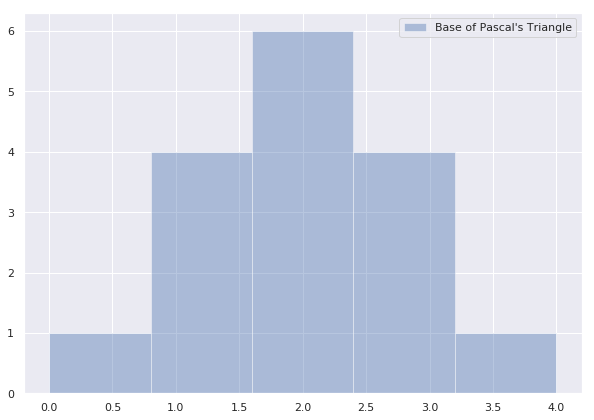

In [43]:
size = 5
p = ndplex(size,edges=2)
y = p.diag(loc=(size-1,0),move=(-1,1))
diag_as_hist(y, labels=['Base of Pascal\'s Triangle'], normed=False)

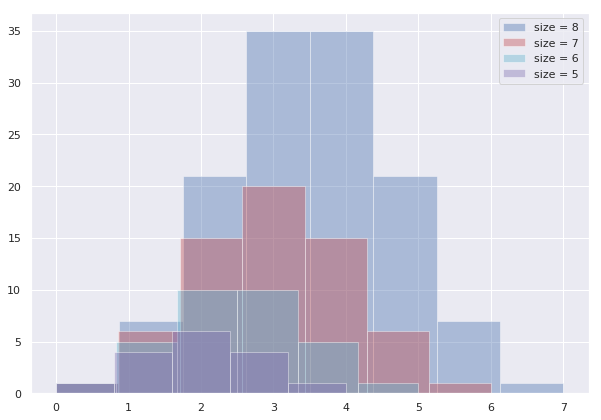

In [44]:
sizes = [8,7,6,5] #the last one is in front

y, labels = [],[]
for size in sizes:   
    p = ndplex(size)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append("size = " + str(size))
    
diag_as_hist(y, labels=labels, normed=False)

#### An oscillating function

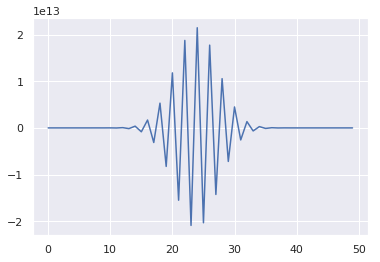

In [45]:
size = 50
func = lambda x: x[0]-x[1]
p = ndplex(size,edges=2,dtype=np.float, func=func)
y = p.diag(loc=(size-1,0),move=(-1,1))
sns.lineplot(x=np.arange(len(y)), y=y)

In [46]:
p = ndplex(9,edges=2,dtype=int, func=func)
p

ndplex([[    1,     1,     1,     1,     1,     1,     1,     1,     1],
        [    1,     0,     1,     0,     1,     0,     1,     0,     1],
        [    1,    -1,     2,    -2,     3,    -3,     4,    -4,     5],
        [    1,    -2,     4,    -6,     9,   -12,    16,   -20,    25],
        [    1,    -3,     7,   -13,    22,   -34,    50,   -70,    95],
        [    1,    -4,    11,   -24,    46,   -80,   130,  -200,   295],
        [    1,    -5,    16,   -40,    86,  -166,   296,  -496,   791],
        [    1,    -6,    22,   -62,   148,  -314,   610, -1106,  1897],
        [    1,    -7,    29,   -91,   239,  -553,  1163, -2269,  4166]])

Notice that row 3 alternates the squares and the standard 3D array's [1,1,:] series, also known as the oblong numbers . See https://oeis.org/A002378

In [47]:
p[3]

ndplex([  1,  -2,   4,  -6,   9, -12,  16, -20,  25])

#### Adjacent Diagonal Number Ratios

In [0]:
def adj_ratios(g):
    ratios = g[1:]/g[:-1]
    print("first 5 ratios =", ratios[:5])
    print("last = ",ratios[-1])
    sns.lineplot(x=np.arange(len(g)-1), y=ratios)

The ratio of adjacent numbers on the main diagonal of a standard Pascal's rectangle appears to converge on 4.

first 5 ratios = [2.         3.         3.33333333 3.5        3.6       ]
last =  3.9797979797979797


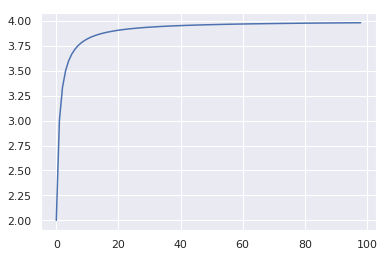

In [49]:
size = 100
g = ndplex(size,edges=2,dtype=np.float).diag()
adj_ratios(g)

This appears to remain true when changing the `edges` parameter,

first 5 ratios = [1.5        3.         3.33333333 3.5        3.6       ]
last =  3.9797979797979797


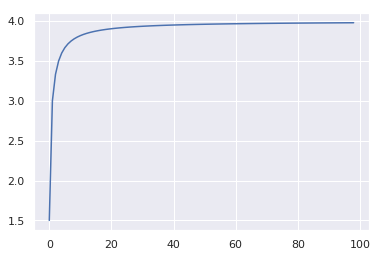

In [50]:
edges = (1, 2)
g = ndplex(size,edges=edges,dtype=np.float).diag()
adj_ratios(g)

first 5 ratios = [       inf 3.5        3.57142857 3.64       3.69230769]
last =  3.9800677966101694


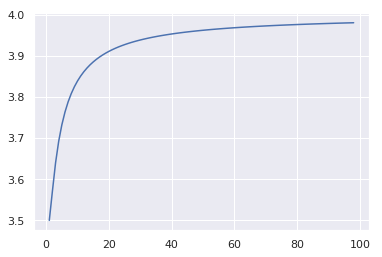

In [51]:
nums = np.arange(100)

edges = (1, nums)
g = ndplex(size,edges=edges,dtype=np.float).diag()
adj_ratios(g)

even when the `edges` go in opposite directions

first 5 ratios = [       inf 3.         3.33333333 3.5        3.6       ]
last =  3.97979797979798


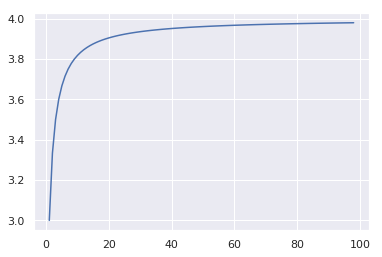

In [52]:
nums = np.arange(100)
dnums = np.flip(nums)

edges = (dnums, nums)
g = ndplex(size,edges=edges,dtype=np.float).diag()
adj_ratios(g)

...but not when when changing the `func` parameter.

first 5 ratios = [3.         5.66666667 6.52941176 6.92792793 7.15604681]
last =  7.959504291616377


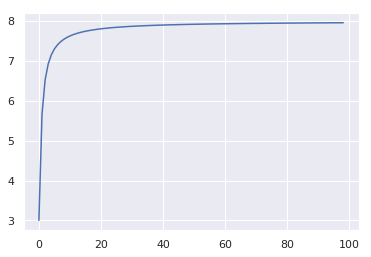

In [53]:
edges = (1,1)
func = lambda x: x[0]+x[1]*2
g = ndplex(size,edges=edges,func=func, dtype=np.float).diag()
adj_ratios(g)

### Visualizing 2D patterns with heatmaps and modular math

#### Checking for the occurence of 1 or more items

Use a heatmap to look for the occurence of perfect squares within a standard Pascal's rectangle. Refer to the following for available color palettes:
* https://seaborn.pydata.org/tutorial/color_palettes.html
* http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3

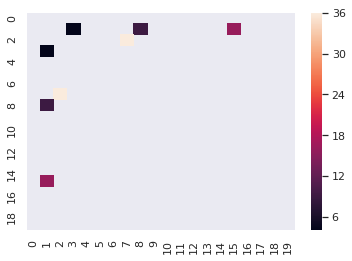

In [54]:
import pandas as pd
size = 20

b = ndplex(size, dtype=np.int64)

max_sqrt = np.int64(np.max(b)**0.5+1)
squares = np.arange(2,max_sqrt)**2

df = pd.DataFrame(b)
sns.heatmap(df.mask(~df.isin(squares)))

#### Modular Math and Fractals

Let's start with creating a fractal. See here for background: http://orion.math.iastate.edu/reu/oldREU/modupasc.htm

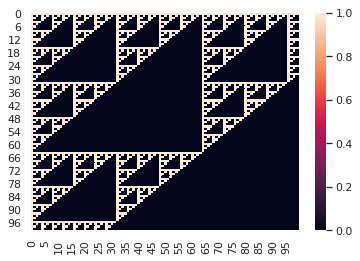

In [55]:
size = 100
divisor = 2
mod = lambda x: x%divisor
a = ndplex(size)
sns.heatmap(mod(a))

What happens if the divisor is 5? Notice how the fractal pattern is maintained until around column 16 and then descends into chaos? Why?

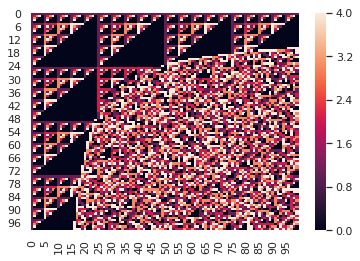

In [56]:
size = 100
divisor = 5
mod = lambda x: x%divisor
a = ndplex(size,dtype=np.int64)
sns.heatmap(mod(a))

Which does not happen if hte divisor is a power of two.

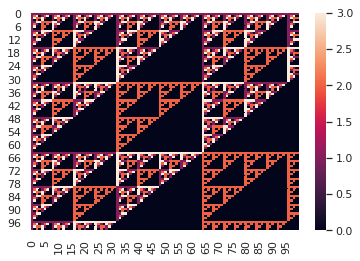

In [57]:
size = 100
divisor = 4
mod = lambda x: x%divisor
a = ndplex(size,dtype=np.int64)
sns.heatmap(mod(a))

Use colorbrewer to choose other colormaps: http://colorbrewer2.org/#type=sequential&scheme=YlOrBr&n=7

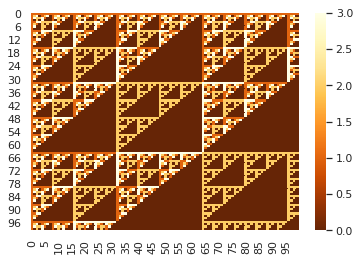

In [58]:
sns.heatmap(mod(a),cmap="YlOrBr_r")

## Applications

### Geometry

See for background:
* https://www.amazon.com/Simplex-Duplex-Pascals-Triangles-Excursions/dp/1514677091 
* https://en.wikipedia.org/wiki/Hypercube
* https://en.wikipedia.org/wiki/Simplex
* `as_tri` for  triangular --> tetrahedral --> n-simplex numbers: proof by Induction?

In [59]:
size = 7
n = 1
left_edge = n**np.arange(size) #powers of n
rule = lambda x: n*x[0] + x[1] 
#if n==1, this is Pascal's Rule; if n==2, the duplex rule; etc
simplex = ndplex(size, edges=(left_edge,1), func=rule)
simplex.as_tri()

array([[ 1,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  0,  0],
       [ 1,  2,  1,  0,  0,  0,  0],
       [ 1,  3,  3,  1,  0,  0,  0],
       [ 1,  4,  6,  4,  1,  0,  0],
       [ 1,  5, 10, 10,  5,  1,  0],
       [ 1,  6, 15, 20, 15,  6,  1]])

In [60]:
simplex.as_tri(sums=True)

array([ 1,  2,  4,  8, 16, 32, 64])

In [61]:
size = 7
n = 2
left_edge = n**np.arange(size) #powers of n
rule = lambda x: n*x[0] + x[1] 
duplex = ndplex(size, edges=(left_edge,1), func=rule)
duplex.as_tri()

array([[  1,   0,   0,   0,   0,   0,   0],
       [  2,   1,   0,   0,   0,   0,   0],
       [  4,   4,   1,   0,   0,   0,   0],
       [  8,  12,   6,   1,   0,   0,   0],
       [ 16,  32,  24,   8,   1,   0,   0],
       [ 32,  80,  80,  40,  10,   1,   0],
       [ 64, 192, 240, 160,  60,  12,   1]])

In [62]:
duplex.as_tri(sums=True)

array([  1,   3,   9,  27,  81, 243, 729])

Row 1 of this triangle are the elements of a line segment (i.e. a 1D duplex): 2 vertices and 1 line segment.

Row 2 of this triange are the elements of a square (i.e. a 2D duplex): 4 vertices, 4 faces, and 1 square.

Row 3  are the elements of a cube (i.e. a 3D duplex): 8 vertices, 12 edges, 6 faces, and 1 cube.

and so on

In [63]:
duplex.as_tri()[3]

array([ 8, 12,  6,  1,  0,  0,  0])

...and here is a triplex triangle. If `power` is set to 4, then it's a quadplex triange.

In [64]:
size = 7
n = 3
left_edge = n**np.arange(size) #powers of n
rule = lambda x: n*x[0] + x[1] 
triplex = ndplex(size, edges=(left_edge,1), func=rule)
triplex.as_tri()

array([[   1,    0,    0,    0,    0,    0,    0],
       [   3,    1,    0,    0,    0,    0,    0],
       [   9,    6,    1,    0,    0,    0,    0],
       [  27,   27,    9,    1,    0,    0,    0],
       [  81,  108,   54,   12,    1,    0,    0],
       [ 243,  405,  270,   90,   15,    1,    0],
       [ 729, 1458, 1215,  540,  135,   18,    1]])

In [65]:
triplex.as_tri(sums=True)

array([   1,    4,   16,   64,  256, 1024, 4096])

Here is a visual comparison of the bases of the the n-plex triangles through n=4:

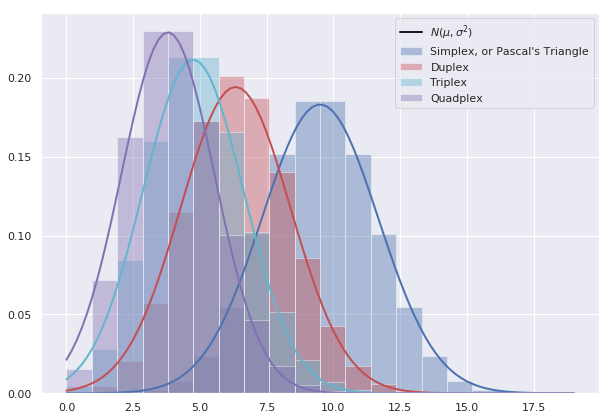

In [66]:
size = 20

plexes = [[1, "Simplex, or Pascal\'s Triangle"], 
          [2, "Duplex"],
          [3, "Triplex"],
          [4, "Quadplex"]]

y, labels = [],[]
for plex in plexes:
    n = plex[0] 
    powers = n**np.arange(size)
    rule = lambda x: n*x[0] + x[1] 
    p = ndplex(size, edges=(powers,1), func=rule, dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(plex[1])

diag_as_hist(y, labels=labels, normed=True)

#### Demonstrating the Triangular Numbers: The Special Case of `func=lambda x:1`

Recall that row 2 of the standard array are the triangular numbers. https://oeis.org/A000217

In [67]:
ndplex(9)[2]

ndplex([ 1,  3,  6, 10, 15, 21, 28, 36, 45])

We can demonstrate that this is true by creating a 2D array with the special case of `func=lambda x:1`.

In [68]:
p_ones_2D = ndplex(9,edges=2,func=lambda x: 1)
p_ones_2D

ndplex([[1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])

Then arrange as a triangle with the `as_tri` function.

In [69]:
p_ones_2D.as_tri()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1]])

and take the cululative sum of each row.

In [70]:
p_ones_2D.as_tri(sums=True).cumsum(-1)

array([ 1,  3,  6, 10, 15, 21, 28, 36, 45])

And recall that row 3 of the standard array are the tetrahedral numbers. https://oeis.org/A000292

In [71]:
ndplex(5)[3]

ndplex([ 1,  4, 10, 20, 35])

We can demonstrate that this is true by creating a 3D array with the special case of `func=lambda x:1`

In [72]:
p_ones_3D = ndplex(5,edges=3,func=lambda x:1)
p_ones_3D

ndplex([[[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]],

        [[1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1],
         [1, 1, 1, 1, 1]]])

then arrange as a tetrahedron with the `as_tri` function

In [73]:
p_ones_3D.as_tri()

array([[[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 0, 0, 0, 0]]])

If we then take the cumulative sums of by layer, we'll see that we get the tetrahedral numbers.

In [74]:
p_ones_3D.as_tri(sums=True).cumsum(-1)

array([ 1,  4, 10, 20, 35])

We can similarly demostrate that row four of the of the standard array...

In [75]:
ndplex(5)[4]

ndplex([ 1,  5, 15, 35, 70])

...are the 4-simplex (i.e. 4-dimensional triangle) numbers:

In [76]:
p_ones_4D = ndplex(5,edges=4,func=lambda x:1)
p_ones_4D.as_tri(sums=True).cumsum(-1)

array([ 1,  5, 15, 35, 70])

### Probability and Statistics

How Pascal's Triangle is related to the bell curve: http://www.ams.org/publicoutreach/feature-column/fcarc-normal

Whereas the base of a Pascal's triangle is a binomial distribution, it approaches the normal distribution as the size increases.

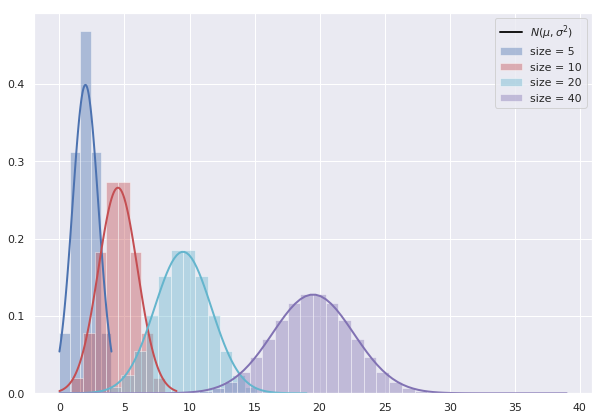

In [77]:
sizes = [5,10,20,40]

y, labels = [],[]
for size in sizes:   
    p = ndplex(size, dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append("size = " + str(size))
    
diag_as_hist(y, labels=labels, normed=True)

The fit to a bell curve applies even in the case of *non-standard* arrays. Compare different values of  the `edges` parameter.

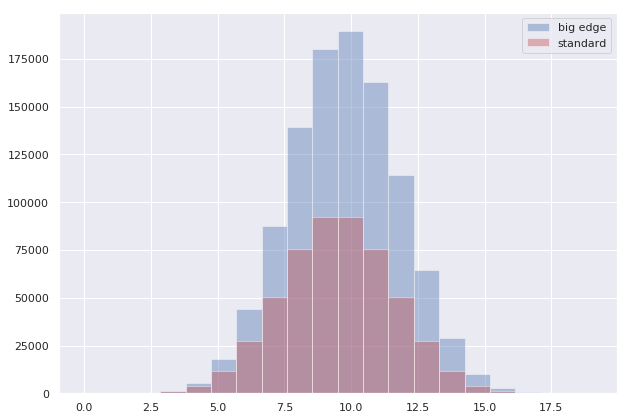

In [78]:
size = 20
edges_list = [[(1,3), "big edge"], 
              [(1,1), "standard"]]

y, labels = [],[]
for edges in edges_list:
    p = ndplex(size,edges=edges[0],dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(edges[1])
    
diag_as_hist(y, labels=labels, normed=False)

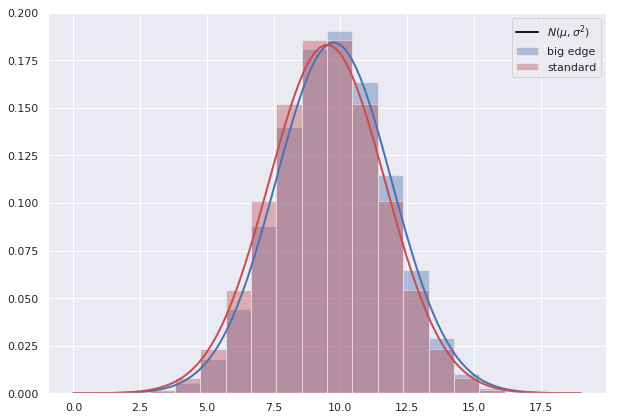

In [79]:
diag_as_hist(y, labels=labels, normed=True)

Compare different values of  the `func` parameter.

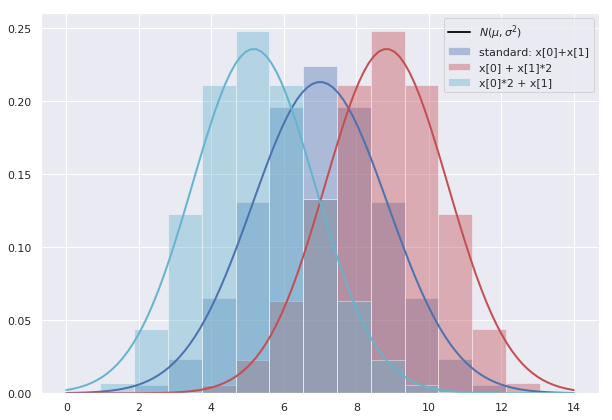

In [80]:
size = 15

func_list = [[lambda x: x[0]+x[1], "standard: x[0]+x[1]"], 
             [lambda x: x[0]+x[1]*2, "x[0] + x[1]*2"],
             [lambda x: x[0]*2+x[1], "x[0]*2 + x[1]"]]

y, labels = [],[]
for f in func_list:
    p = ndplex(size, func=f[0])
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(f[1])
    
diag_as_hist(y, labels=labels, normed=True)

Compare  ascending with descending edges:

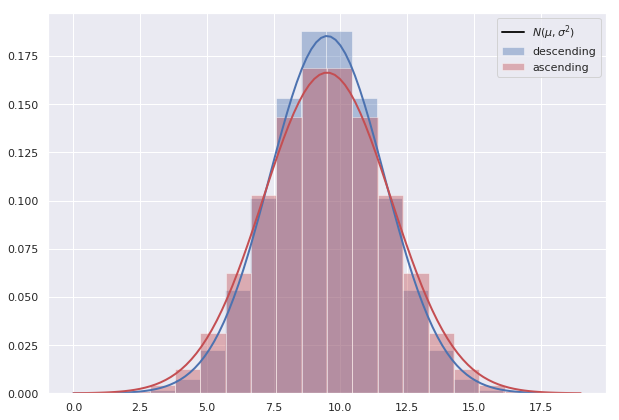

In [81]:
size = 20

nums = np.arange(size)
nums_desc = np.flip(nums)

edges_list = [[(nums_desc,nums_desc), "descending"], 
              [(nums,nums), "ascending"]]

y, labels = [],[]
for edges in edges_list:
    p = ndplex(size,edges=edges[0],dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(edges[1])
    
diag_as_hist(y, labels=labels, normed=True)

Even when the edges are a random shuffle, the chart looks mostly the same:

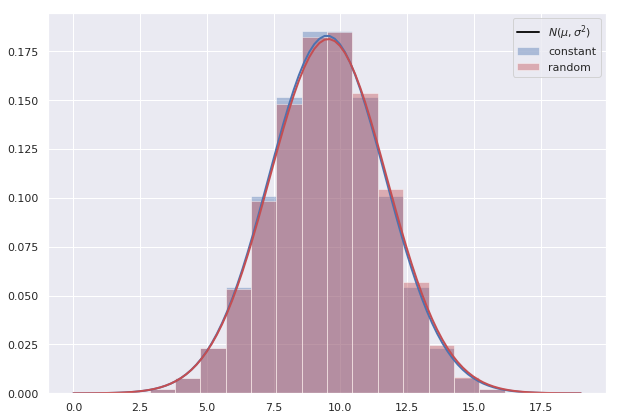

In [82]:
size = 20

nums = np.arange(size)
avg = np.average(nums)

np.random.shuffle(nums)
rando1 = nums.copy()

np.random.shuffle(nums)
rando2 = nums.copy()

edges_list = [[(avg,avg), "constant"], 
              [(rando1,rando2), "random"]]
   
y, labels = [],[]
for edges in edges_list:
    p = ndplex(size,edges=edges[0],dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(edges[1])
    
diag_as_hist(y, labels=labels, normed=True)

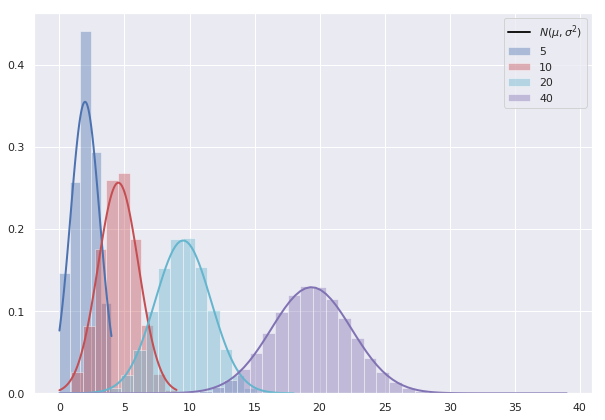

In [83]:
sizes = [5,10,20,40]

y, labels = [],[]
for size in sizes:
    
    nums = np.arange(size)
    avg = np.average(nums)

    np.random.shuffle(nums)
    rando1 = nums.copy()

    np.random.shuffle(nums)
    rando2 = nums.copy()
    
    p = ndplex(size,edges=[rando1,rando2],dtype=np.float)
    y.append(p.diag(loc=(size-1,0),move=(-1,1)))
    labels.append(str(size))
    
diag_as_hist(y, labels=labels, normed=True)

And here is a goofy example. Under what conditions does the histogram not approach the shape of the bell curve?

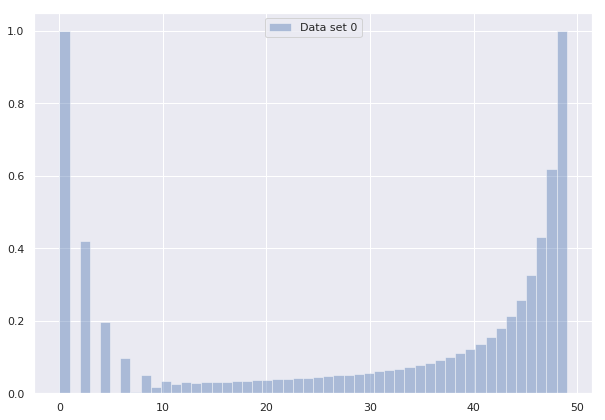

In [84]:
size = 50
func = lambda x: x[0]/(x[1]+1)
p = ndplex(size,func=func, dtype=np.float)
y = p.diag(loc=(size-1,0),move=(-1,1))
diag_as_hist(y, normed=False)

### Fibonacci Numbers, Cows, and Population Growth

In [0]:
def fibonaccis(size):
    fibonaccis = [1,1]
    for i in range(2,size):
        fibonaccis.append(fibonaccis[i-1] + fibonaccis[i-2])
    return fibonaccis

You can get the Fibonaccis by building a series of steep diagonals, like this.

In [86]:
p=ndplex(9)
p.diag(move=[(-2,1),(1,0)],sum_axis=None)

array([[ 1,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0],
       [ 1,  2,  0,  0,  0],
       [ 1,  3,  1,  0,  0],
       [ 1,  4,  3,  0,  0],
       [ 1,  5,  6,  1,  0],
       [ 1,  6, 10,  4,  0],
       [ 1,  7, 15, 10,  1]])

but summing each row.

In [87]:
p.diag(move=[(-2,1),(1,0)],sum_axis=1)

array([ 1,  1,  2,  3,  5,  8, 13, 21, 34])

Ratio of successive Fibonaccis approaches the Golden Ratio.

In [88]:
fibs = ndplex(50).diag(move=[(-2,1),(1,0)],sum_axis=1)
fibs[-1]/fibs[-2]

1.618033988749895

Instead of moving up 2 as in the case of the Fibonaccis above, let's try moving up 3:

In [89]:
p.diag(move=[(-3,1),(1,0)],sum_axis=1)

array([ 1,  1,  1,  2,  3,  4,  6,  9, 13])

which turns out to be the Narayana's cows sequence (https://oeis.org/A000930; See also http://jim.afim-asso.org/jim96/actes/Allouche.ps), a model of population growth. So, how many cows and calves can we expect to have after 20 years?

In [90]:
year = 20
cow_population = ndplex(50).diag(move=[(-3,1),(1,0)],sum_axis=1)
cow_population[year]

1278

But this neglects the death of the first cows. So how do we account for mortality? Subtract diagonals with an offset equal to the reproductive lifespan. 

In [91]:
lifespan = 6
cow_pop2 = cow_population[lifespan:] - cow_population[:-lifespan]
cow_pop2[year-lifespan]

1149

is how many cows and calves we can expect after 20 years.

Now, what happens when we sum diagonals, starting with the horizontal, then incrementally increase the slope?

In [92]:
size = 10
d = ndplex(size)
b=np.zeros(size,int)
for i in range(1,size+1):
    b = np.append(b,d.diag(move=[(-i,1),(1,0)],sum_axis=1))
b=np.trim_zeros(b)
b = b.reshape(size,-1) #-1 means the second dimension inferred from other values
b

array([[  1,   2,   4,   8,  16,  32,  64, 128, 256, 512],
       [  1,   1,   2,   3,   5,   8,  13,  21,  34,  55],
       [  1,   1,   1,   2,   3,   4,   6,   9,  13,  19],
       [  1,   1,   1,   1,   2,   3,   4,   5,   7,  10],
       [  1,   1,   1,   1,   1,   2,   3,   4,   5,   6],
       [  1,   1,   1,   1,   1,   1,   2,   3,   4,   5],
       [  1,   1,   1,   1,   1,   1,   1,   2,   3,   4],
       [  1,   1,   1,   1,   1,   1,   1,   1,   2,   3],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   2],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1,   1]])

which can be found here: https://oeis.org/A141539. The first three rows are, respectively, the powers of 2, Fibonaccis, and Narayana's cows sequence. 

In [93]:
oeis(b)

OEIS Search Results
row 0: http://oeis.org/A000079 Powers of 2: a(n) = 2^n.
row 1: http://oeis.org/A000045 Fibonacci numbers: F(n) = F(n-1) + F(n-2) with F(0) = 0 and F(1) = 1.
row 2: http://oeis.org/A000930 Narayana's cows sequence: a(0) = a(1) = a(2) = 1; thereafter a(n) = a(n-1) + a(n-3).
row 3: http://oeis.org/A003269 a(n) = a(n-1) + a(n-4) with a(0) = 0, a(1) = a(2) = a(3) = 1.
row 4: http://oeis.org/A003520 a(n) = a(n-1) + a(n-5); a(0) = ... = a(4) = 1.
row 5: http://oeis.org/A005708 a(n) = a(n-1) + a(n-6), with a(i) = 1 for i = 0..5.
row 6: http://oeis.org/A003989 Triangle T from the array A(x, y) = gcd(x,y), for x >= 1, y >= 1, read by antidiagonals.
row 7: http://oeis.org/A008406 Triangle T(n,k) read by rows, giving number of graphs with n nodes (n >= 1) and k edges (0 <= k <= n(n-1)/2).
row 8: http://oeis.org/A055642 Number of digits in decimal expansion of n.
row 9: http://oeis.org/A000012 The simplest sequence of positive numbers: the all 1's sequence.


Compare the diagonals. `move = (-1,1)` is the base of Pascal's Triangle and is symmetrical. `move = (-2,1)` is the diagonal summed to get a Fibonnaci number. 

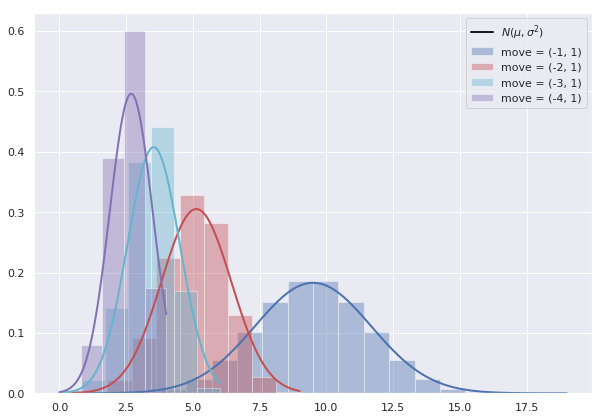

In [94]:
size = 20
p = ndplex(size,edges=2,dtype=np.float)

z, labels = [], []
for i in range(1,5):
    move = (-i,1)
    y = p.diag(loc=(size-1,0),move=move)
    z.append(y)
    labels.append("move = " + str(move))

diag_as_hist(z, labels=labels, normed=True)

Now let's build a `ndplex` with the Fibonacci numbers on the edges.

In [95]:
size = 9
f = fibonaccis(size)
fplex = ndplex(size, edges=(f,f))
fplex

ndplex([[    1,     1,     2,     3,     5,     8,    13,    21,    34],
        [    1,     2,     4,     7,    12,    20,    33,    54,    88],
        [    2,     4,     8,    15,    27,    47,    80,   134,   222],
        [    3,     7,    15,    30,    57,   104,   184,   318,   540],
        [    5,    12,    27,    57,   114,   218,   402,   720,  1260],
        [    8,    20,    47,   104,   218,   436,   838,  1558,  2818],
        [   13,    33,    80,   184,   402,   838,  1676,  3234,  6052],
        [   21,    54,   134,   318,   720,  1558,  3234,  6468, 12520],
        [   34,    88,   222,   540,  1260,  2818,  6052, 12520, 25040]])

In [96]:
oeis(fplex.as_tri())

OEIS Search Results
row 0: http://oeis.org/A010054 a(n) = 1 if n is a triangular number, otherwise 0.
row 1: http://oeis.org/A051731 Triangle read by rows: T(n,k) = 1 if k divides n, T(n,k) = 0 otherwise (for n >= 1 and 1 <= k <= n).
row 2: http://oeis.org/A204263 Symmetric matrix: f(i,j)=(i+j mod 3), by antidiagonals.
row 3: http://oeis.org/A180472 Triangle T(n, k) = OC(n, k; not -1), read by rows, where OC(n, k; not -1) is the number of k-subsets of Z_n without -1 as a multiplier, up to congruency.
row 4: no match
row 5: no match
row 6: no match
row 7: no match
row 8: http://oeis.org/A074829 Triangle formed by Pascal's rule, except begin and end the n-th row with the n-th Fibonacci number.


Here is a puzzler: We put the fibbonacci's on the first row of an otherwise default ndplex. We then heatmap the array modulo 7. What accounts for the diagonal stripes?

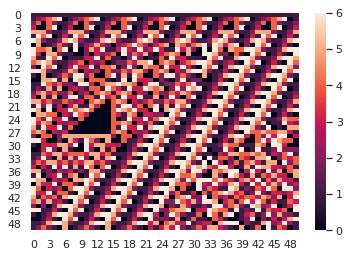

In [97]:
size = 50
divisor = 7
a = ndplex(size, edges=(fibonaccis(size),1))
sns.heatmap(a%divisor)

#### Another way to estimate the Golden Ratio:

1.618033985017358


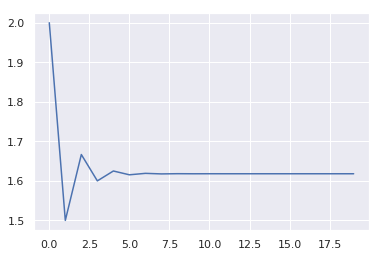

In [98]:
size = 20
func = lambda x: (x[0]+x[1])/x[0]
p2= ndplex(size,edges=(1,range(1,size+1)),func=func,dtype=float)
y = p2.diag(loc=(0,1), move=(1,0))
x = np.arange(size)
sns.lineplot(x,y)
print(y[-1])

### Moving Costs, Turnover, and Rental Rates

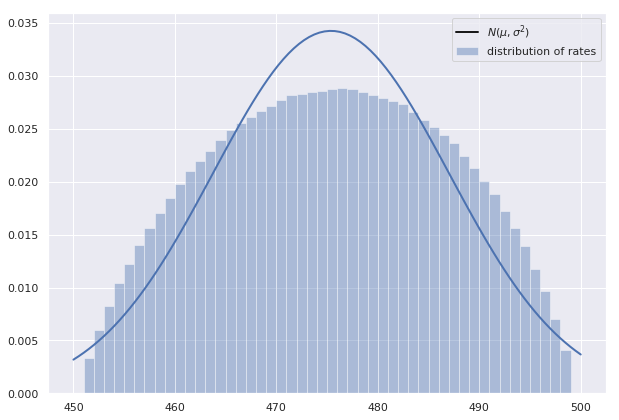

Average rental rate = $475.96


In [99]:
size = 50  # either number of lease periods or number of rental units

turnover = 0.4 # fraction of tenants per lease period which move out
renewals = 1 - turnover # fraction of tenants which renew their leases

moving_costs = 600 
market_rent_rate = 450
renewal_rent_rate = market_rent_rate + moving_costs/12.0
# assumes that rational tenants are willing to renew if the new rental rate
# is less than or equal to the market rent plus prorated moving costs

f = lambda x: x[1]*renewals + x[0]*turnover #weighted average rental rate
p_rates = ndplex(size,edges=[renewal_rent_rate, market_rent_rate],
                 func=f,dtype=float)
rental_rates = p_rates.diag(loc=[size-1,0], move=[-1,1])

f2 = lambda x: x[1]*renewals/turnover + x[0] #weighted average renewed
p_occs = ndplex(size, func=f2, dtype=float)
weights = p_occs.diag(loc=[size-1,0], move=[-1,1])

# fill in the gaps
newx = np.linspace(min(rental_rates),max(rental_rates),size)
rental_rates, weights  = zip(*sorted(zip(rental_rates, weights)))
newy = np.interp(newx, xp=rental_rates, fp=weights)

diag_as_hist(newy, x_values=newx, normed=True, labels=['distribution of rates'])
avg_rental_rate = np.average(rental_rates,weights=weights).round(2)
print("Average rental rate = $" + str(avg_rental_rate))

### Searching for Patterns among the Primes

some ideas
* func: left divisible by right
* func: left modulo right
* primes triangle analog to duplex triangle
* first and second differences
* varying `arg_locs`

In [0]:
#primes, first 1000
target_url = 'https://gist.githubusercontent.com/cblanc/46ebbba6f42f61e60666/raw/8306166ecb892cedb0555f87eaa4f5f7e02980de/gistfile1.txt'
response = requests.get(target_url)
primes = response.text.split(",")
primes = list(map(int, primes))
    
    
# https://stackoverflow.com/questions/2068372/fastest-way-to-list-all-primes-below-n/3035188#3035188
def primesfrom2to(n):
    """ Input n>=6, Returns a array of primes, 2 <= p < n """
    sieve = np.ones(n//3 + (n%6==2), dtype=np.bool)
    for i in range(1,int(n**0.5)//3+1):
        if sieve[i]:
            k=3*i+1|1
            sieve[       k*k//3     ::2*k] = False
            sieve[k*(k-2*(i&1)+4)//3::2*k] = False
    return np.r_[2,3,((3*np.nonzero(sieve)[0][1:]+1)|1)]

#### edges=(primes, constant, ...)

Let's put the primes in row 0. Row 1 is interesting in that no numbers are prime: see https://oeis.org/A138981

In [101]:
size = 8
p = primes[:size]
ndplex(size, edges=(1, p))

ndplex([[   2,    3,    5,    7,   11,   13,   17,   19],
        [   1,    4,    9,   16,   27,   40,   57,   76],
        [   1,    5,   14,   30,   57,   97,  154,  230],
        [   1,    6,   20,   50,  107,  204,  358,  588],
        [   1,    7,   27,   77,  184,  388,  746, 1334],
        [   1,    8,   35,  112,  296,  684, 1430, 2764],
        [   1,    9,   44,  156,  452, 1136, 2566, 5330],
        [   1,   10,   54,  210,  662, 1798, 4364, 9694]])

Set the left edge to be to so that both edges share a common origin.

In [102]:
ndplex(size, edges=(2, p))

ndplex([[    2,     3,     5,     7,    11,    13,    17,    19],
        [    2,     5,    10,    17,    28,    41,    58,    77],
        [    2,     7,    17,    34,    62,   103,   161,   238],
        [    2,     9,    26,    60,   122,   225,   386,   624],
        [    2,    11,    37,    97,   219,   444,   830,  1454],
        [    2,    13,    50,   147,   366,   810,  1640,  3094],
        [    2,    15,    65,   212,   578,  1388,  3028,  6122],
        [    2,    17,    82,   294,   872,  2260,  5288, 11410]])

...or 1 if you assume the primes start with 1.

In [103]:
p = [1] + list(primes[:size-1])
arg_locs = [[-1,0],[0,-1]]
prime_matrix = ndplex(size, edges=(1, p), arg_locs=arg_locs)
prime_matrix

ndplex([[   1,    2,    3,    5,    7,   11,   13,   17],
        [   1,    3,    6,   11,   18,   29,   42,   59],
        [   1,    4,   10,   21,   39,   68,  110,  169],
        [   1,    5,   15,   36,   75,  143,  253,  422],
        [   1,    6,   21,   57,  132,  275,  528,  950],
        [   1,    7,   28,   85,  217,  492, 1020, 1970],
        [   1,    8,   36,  121,  338,  830, 1850, 3820],
        [   1,    9,   45,  166,  504, 1334, 3184, 7004]])

In [104]:
oeis(prime_matrix)

OEIS Search Results
row 0: http://oeis.org/A008578 Prime numbers at the beginning of the 20th century (today 1 is no longer regarded as a prime).
row 1: http://oeis.org/A014284 Partial sums of primes, if 1 is regarded as a prime (as it was until quite recently, see A008578).
row 2: http://oeis.org/A023538 Convolution of natural numbers with (1, p(1), p(2), ... ), where p(k) is the k-th prime.
row 3: no match
row 4: no match
row 5: no match
row 6: no match
row 7: no match


In [105]:
prime_matrix.diag()

array([   1,    3,   10,   36,  132,  492, 1850, 7004])

In [106]:
prime_matrix.as_tri(sums=True)

array([  1,   3,   7,  16,  34,  72, 146, 296])

#### edges=(primes, primes, ...)

In [107]:
size = 9
p = primes[:size]
prime_matrix = ndplex(size, edges=(p, p))
prime_matrix

ndplex([[    2,     3,     5,     7,    11,    13,    17,    19,    23],
        [    3,     6,    11,    18,    29,    42,    59,    78,   101],
        [    5,    11,    22,    40,    69,   111,   170,   248,   349],
        [    7,    18,    40,    80,   149,   260,   430,   678,  1027],
        [   11,    29,    69,   149,   298,   558,   988,  1666,  2693],
        [   13,    42,   111,   260,   558,  1116,  2104,  3770,  6463],
        [   17,    59,   170,   430,   988,  2104,  4208,  7978, 14441],
        [   19,    78,   248,   678,  1666,  3770,  7978, 15956, 30397],
        [   23,   101,   349,  1027,  2693,  6463, 14441, 30397, 60794]])

In [108]:
prime_matrix.diag()

array([    2,     6,    22,    80,   298,  1116,  4208, 15956, 60794])

In [109]:
prime_matrix.as_tri(sums=True)

array([   2,    6,   16,   36,   80,  164,  336,  676, 1360])

Now lets start the primes with 1 and display the main diagonal.

In [110]:
p = [1] + list(primes[:size - 1])
prime_matrix = ndplex(size, edges=(p, p))
prime_matrix

ndplex([[    1,     2,     3,     5,     7,    11,    13,    17,    19],
        [    2,     4,     7,    12,    19,    30,    43,    60,    79],
        [    3,     7,    14,    26,    45,    75,   118,   178,   257],
        [    5,    12,    26,    52,    97,   172,   290,   468,   725],
        [    7,    19,    45,    97,   194,   366,   656,  1124,  1849],
        [   11,    30,    75,   172,   366,   732,  1388,  2512,  4361],
        [   13,    43,   118,   290,   656,  1388,  2776,  5288,  9649],
        [   17,    60,   178,   468,  1124,  2512,  5288, 10576, 20225],
        [   19,    79,   257,   725,  1849,  4361,  9649, 20225, 40450]])

In [111]:
prime_matrix.diag()

array([    1,     4,    14,    52,   194,   732,  2776, 10576, 40450])

In [112]:
prime_matrix.as_tri(sums=True)

array([  1,   4,  10,  24,  52, 112, 228, 464, 932])

In [113]:
prime_matrix[1]

ndplex([ 2,  4,  7, 12, 19, 30, 43, 60, 79])

#### edges=(primes, nonconstant, ...)

In [114]:
size = 9
p = primes[:size]
c = np.arange(size)+2
prime_matrix2 = ndplex(size, edges=(c,p))
prime_matrix2

ndplex([[    2,     3,     5,     7,    11,    13,    17,    19,    23],
        [    3,     6,    11,    18,    29,    42,    59,    78,   101],
        [    4,    10,    21,    39,    68,   110,   169,   247,   348],
        [    5,    15,    36,    75,   143,   253,   422,   669,  1017],
        [    6,    21,    57,   132,   275,   528,   950,  1619,  2636],
        [    7,    28,    85,   217,   492,  1020,  1970,  3589,  6225],
        [    8,    36,   121,   338,   830,  1850,  3820,  7409, 13634],
        [    9,    45,   166,   504,  1334,  3184,  7004, 14413, 28047],
        [   10,    55,   221,   725,  2059,  5243, 12247, 26660, 54707]])

In [115]:
size = 9
p = [1] + list(primes[:size-1])
c = np.arange(size)+1
prime_matrix1 = ndplex(size, edges=(c,p))
prime_matrix1

ndplex([[    1,     2,     3,     5,     7,    11,    13,    17,    19],
        [    2,     4,     7,    12,    19,    30,    43,    60,    79],
        [    3,     7,    14,    26,    45,    75,   118,   178,   257],
        [    4,    11,    25,    51,    96,   171,   289,   467,   724],
        [    5,    16,    41,    92,   188,   359,   648,  1115,  1839],
        [    6,    22,    63,   155,   343,   702,  1350,  2465,  4304],
        [    7,    29,    92,   247,   590,  1292,  2642,  5107,  9411],
        [    8,    37,   129,   376,   966,  2258,  4900, 10007, 19418],
        [    9,    46,   175,   551,  1517,  3775,  8675, 18682, 38100]])

Taking the difference between the above two arrays:

In [116]:
prime_matrix_diff = prime_matrix2 - prime_matrix1
prime_matrix_diff

ndplex([[    1,     1,     2,     2,     4,     2,     4,     2,     4],
        [    1,     2,     4,     6,    10,    12,    16,    18,    22],
        [    1,     3,     7,    13,    23,    35,    51,    69,    91],
        [    1,     4,    11,    24,    47,    82,   133,   202,   293],
        [    1,     5,    16,    40,    87,   169,   302,   504,   797],
        [    1,     6,    22,    62,   149,   318,   620,  1124,  1921],
        [    1,     7,    29,    91,   240,   558,  1178,  2302,  4223],
        [    1,     8,    37,   128,   368,   926,  2104,  4406,  8629],
        [    1,     9,    46,   174,   542,  1468,  3572,  7978, 16607]])

Row 0 is maybe https://oeis.org/A075526 and column 2 is maybe the lazy caterer's sequence: https://oeis.org/A000124

In [117]:
prime_matrix_diff.diagonal()

ndplex([    1,     2,     7,    24,    87,   318,  1178,  4406, 16607])

`prime_matrix_diff` can also be defined this way:

In [118]:
size = 9 

p2 = np.asarray(primes[:size])
p1 = np.asarray([1] + list(primes[:size-1]))
p_diff = p2 - p1

prime_matrix_diff2 = ndplex(size, edges=(1,p_diff))
prime_matrix_diff2

ndplex([[    1,     1,     2,     2,     4,     2,     4,     2,     4],
        [    1,     2,     4,     6,    10,    12,    16,    18,    22],
        [    1,     3,     7,    13,    23,    35,    51,    69,    91],
        [    1,     4,    11,    24,    47,    82,   133,   202,   293],
        [    1,     5,    16,    40,    87,   169,   302,   504,   797],
        [    1,     6,    22,    62,   149,   318,   620,  1124,  1921],
        [    1,     7,    29,    91,   240,   558,  1178,  2302,  4223],
        [    1,     8,    37,   128,   368,   926,  2104,  4406,  8629],
        [    1,     9,    46,   174,   542,  1468,  3572,  7978, 16607]])

In [119]:
oeis(prime_matrix_diff2,trim=True)

OEIS Search Results
row 0: http://oeis.org/A075526 A008578(n+2) - A008578(n+1).
row 1: http://oeis.org/A006093 a(n) = prime(n) - 1.
row 2: http://oeis.org/A101301 The sum of the first n primes, minus n.
row 3: no match
row 4: no match
row 5: no match
row 6: no match
row 7: no match
row 8: no match


Alien invasion

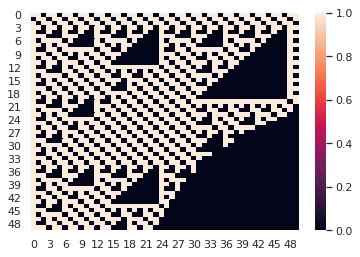

In [120]:
def fibonaccis(size):
    fibonaccis = [1,1]
    for i in range(2,size):
        fibonaccis.append(fibonaccis[i-1] + fibonaccis[i-2])
    return fibonaccis

size = 50
primes = list(primesfrom2to(1000000))
p = [1] + primes[:size - 1]
f = fibonaccis(size)
dingbat = ndplex(size, edges=(p,f),dtype=np.float128)
sns.heatmap(dingbat%2)

#### `func` parameter

In [121]:
size = 7
#p = [1] + list(primes[:size-1])
p = primes[:size]
f = lambda x: 2*x[0] + x[1] #duplex rule
primes_2_duplex = ndplex(size, edges=(p, 2), func=f)
primes_2_duplex

ndplex([[    2,     2,     2,     2,     2,     2,     2],
        [    3,     7,    11,    15,    19,    23,    27],
        [    5,    19,    41,    71,   109,   155,   209],
        [    7,    45,   127,   269,   487,   797,  1215],
        [   11,   101,   355,   893,  1867,  3461,  5891],
        [   13,   215,   925,  2711,  6445, 13367, 25149],
        [   17,   447,  2297,  7719, 20609, 47343, 97641]])

In [122]:
size = 7
p = [1] + list(primes[:size-1])
#p = primes[:size]
f = lambda x: 2*x[0] + x[1] #duplex rule
ndplex(size, edges=(p, 1), func=f)

ndplex([[    1,     1,     1,     1,     1,     1,     1],
        [    2,     4,     6,     8,    10,    12,    14],
        [    3,    11,    23,    39,    59,    83,   111],
        [    5,    27,    73,   151,   269,   435,   657],
        [    7,    61,   207,   509,  1047,  1917,  3231],
        [   11,   133,   547,  1565,  3659,  7493, 13955],
        [   13,   279,  1373,  4503, 11821, 26807, 54717]])

In [123]:
size = 7
p = [1] + list(primes[:size-1])
c = np.arange(size)+1
f = lambda x: 2*x[0] + x[1] #the duplex rule
ndplex(size, edges=(p, c), func=f)

ndplex([[     1,      2,      3,      4,      5,      6,      7],
        [     2,      6,     12,     20,     30,     42,     56],
        [     3,     15,     39,     79,    139,    223,    335],
        [     5,     35,    113,    271,    549,    995,   1665],
        [     7,     77,    303,    845,   1943,   3933,   7263],
        [    11,    165,    771,   2461,   6347,  14213,  28739],
        [    13,    343,   1885,   6807,  19501,  47927, 105405]])

#### More than 2 dimensions.

In [124]:
size = 10
p = [1] + list(primes[:size-1])
prime_xD = ndplex(size, (p,1,1))
prime_xD.diag()

array([           1,            8,          126,         2420,
              50750,      1120896,     25611432,    599439984,
        14284168470, 345153963440])

In [125]:
prime_xD.as_tri(sums=True)

array([    1,     4,    13,    41,   125,   379,  1139,  3421, 10265,
       30799])

#### Adjacent diagonals ratios

In [0]:
def adj_ratios(g):
    ratios = g[1:]/g[:-1]
    print("first 5 ratios =", ratios[:5])
    print("last = ",ratios[-1])
    sns.lineplot(x=np.arange(len(g)-1), y=ratios)

first 5 ratios = [3.         3.66666667 3.63636364 3.725      3.74496644]
last =  3.9802421517818907


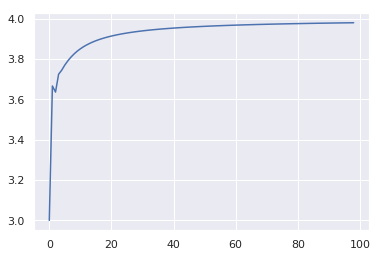

In [127]:
size = 100
#p = [1] + list(primes[:size-1])
p = primes[:size]
prime_matrix_big = ndplex(size, edges=(p,p), dtype=float)

d = prime_matrix_big.diag(loc=(0,0), move=(1,1))
adj_ratios(d)

#### Proximity to the nearest prime number

In [128]:
size = 10

def evens(size): 
    return np.arange(1,size+1)*2

e = evens(size)

func = lambda x: x[0] + x[1] - 1
sam = ndplex(size,edges=(e,e),func=func)

shape = sam.shape
sam = sam.reshape(size**2,1)

primes = primesfrom2to(sam.max())

mod = lambda x: np.abs(primes-x).min()
prox = np.asarray(list(map(mod, sam)))

prox = prox.reshape(shape)

prox

array([[ 0,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  0,  1,  0,  1,  2,  1,  0,  1,  0],
       [ 1,  1,  0,  0,  1,  1,  0,  0,  1,  1],
       [ 1,  0,  0,  2,  1,  2,  0,  0,  1, 16],
       [ 1,  1,  1,  1,  2,  0,  2,  2,  1,  1],
       [ 1,  2,  1,  2,  0,  0,  6,  0,  1,  2],
       [ 1,  1,  0,  0,  2,  6,  0,  0,  1,  3],
       [ 1,  0,  0,  0,  2,  0,  0,  2,  5,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  5,  0,  0],
       [ 1,  0,  1, 16,  1,  2,  3,  0,  0, 16]])

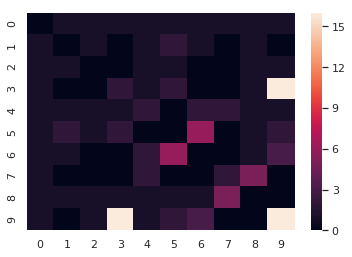

In [129]:
sns.heatmap(prox)